In [1]:
import pandas as pd
import plotly.express as px
import numpy  as np

In [2]:
# Define the function to assign partition based on the node number
def assign_partition(node):
    try:
        # Extract the node number
        node_num = int(node.split('spdr')[-1])
    
        # Define partition ranges
        partition_ranges = {
                            'basic': range(1, 9),
                            'medium': range(9, 14),
                            'large': range(14, 16),
                            'ML': [16],
                            'sci': range(17, 19)}
    
        # Assign partition based on the node number
        for partition, node_range in partition_ranges.items():
            if node_num in node_range:
                return partition
    except Exception as e:
        return 'unknown'

In [3]:
def node_compare(ns, ms, df):
    """
    Create comparison plots for cpu.user_percent, cpu.system_percent, and cpu.idle_percent
    for specific nodes (node01, node13, node59) in the dataset.

    Parameters:
    df (DataFrame): The dataset containing CPU metrics and node information.
    ns (list): List of node names to filter.
    ms (list): List of metric column names to plot.
    """
    try:
        # Filter nodes and add partition column
        df_node = df[df['devices'].isin(ns)].copy()  # Use .copy() to avoid SettingWithCopyWarning
        df_node['partition'] = df_node['devices'].apply(assign_partition)
        
        # Combine 'year', 'month', 'day', 'hour', and 'minute' into a single datetime column for x-axis
        #df_node.loc[:, 'date'] = pd.to_datetime(df_node[['year', 'month', 'day', 'hour', 'minute']])
        
        # Set the index to 'date' for resampling
        df_node.set_index('time', inplace=True)
        
        # Group by 'devices' and 'indices', then resample within each group
        df_resampled = df_node.groupby(['devices', 'indices', 'partition']).resample('10T').mean(numeric_only=True).reset_index()
        
        # Group by partitions and create plots for each partition
        partitions = df_resampled['partition'].unique()
        for partition in partitions:
            df_partition = df_resampled[df_resampled['partition'] == partition]
            for metric in ms:
                metric_df = df_partition[df_partition['indices'] == metric]
                if metric_df.empty:
                    print(f"No data available for metric '{metric}' in partition '{partition}'.")
                    continue
                try:
                    fig = px.line(
                        metric_df,
                        x='time',
                        y='datum',  # Ensure 'datum' is the correct column for the y-axis values
                        color='devices',
                        title=f'Comparison of {metric.replace("_", " ").title()} Over Time for {partition.capitalize()} Nodes',
                        labels={
                            'datum': metric.replace("_", " ").title(),
                            'time': 'Date',
                            'devices': 'Node'
                        }
                    )
                    fig.update_traces(mode='lines+markers')
                    fig.show()
                except Exception as e:
                    print(f"An error occurred while plotting metric '{metric}' for partition '{partition}': {e}")
    except Exception as e:
        print(f"An error occurred in the node_compare function: {e}")

In [5]:
df = pd.read_csv('dataset.csv')
df['time'] = pd.to_datetime(df['time'])
df['partition'] = df['devices'].apply(assign_partition)
#df.to_csv('clusterdata.csv', index=False)

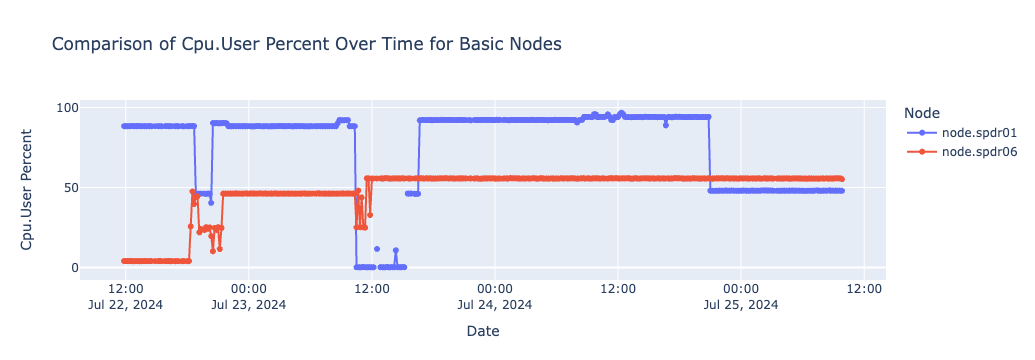

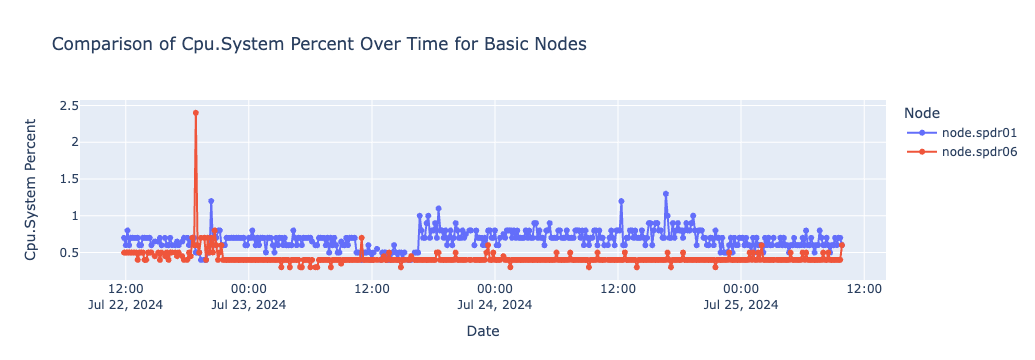

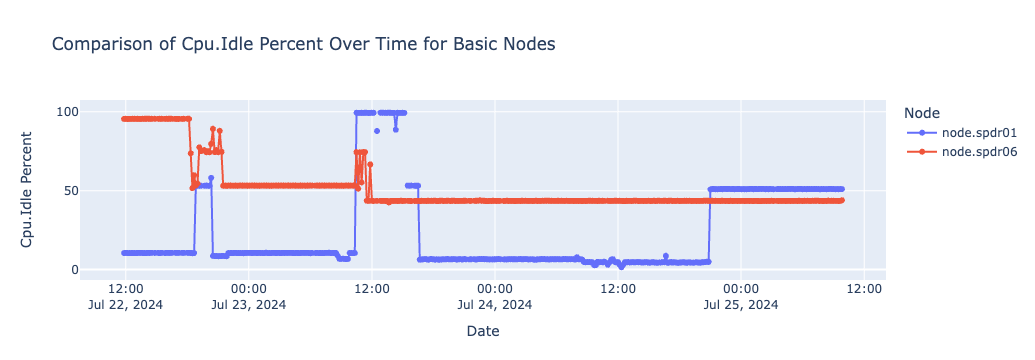

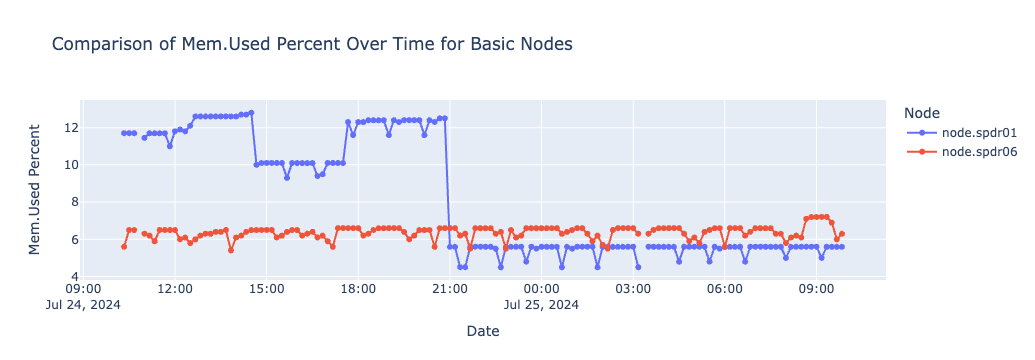

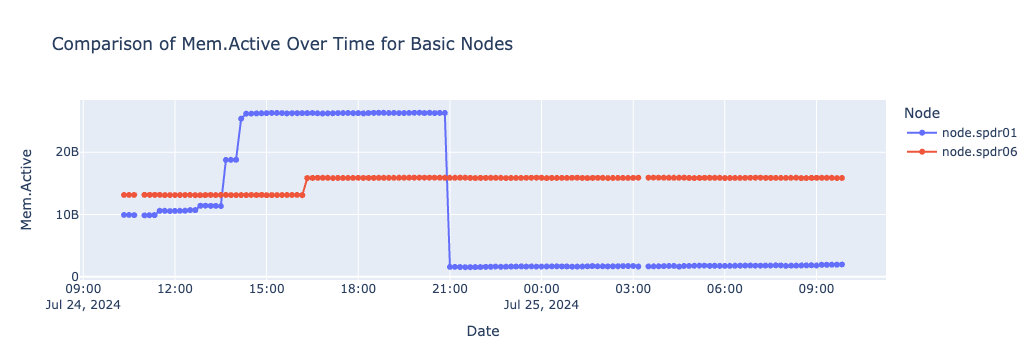

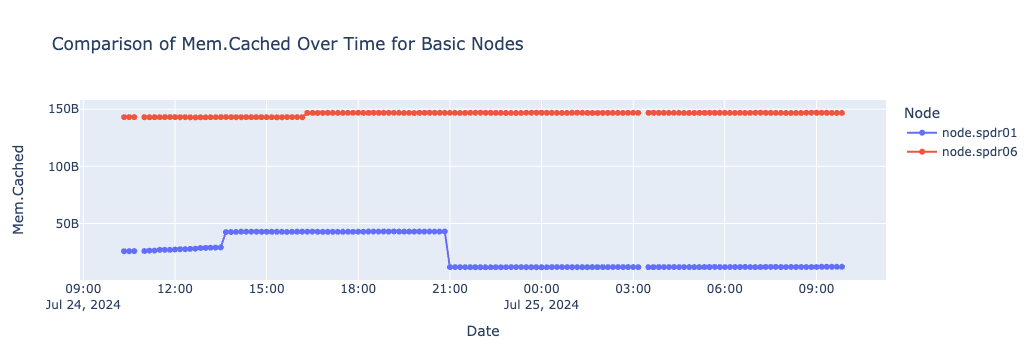

In [335]:
nodes = ['node.spdr01', 'node.spdr06']
ms1 = ['cpu.user_percent', 'cpu.system_percent', 'cpu.idle_percent']
ms2 = ['cpu.load_15', 'cpu.usage_percent', 'cpu.nice_percent', 'cpu.iowait_percent']
ms3 = ['power.cpu_watts', 'power.mem_watts','power.node_watts', 'system.process_count']
ms4 = ['mem.used_percent', 'mem.active','mem.cached']
node_compare(nodes, ms1, df)
node_compare(nodes, ms4, df)

In [305]:
df['indices'].unique()

array(['cpu.user_percent', 'cpu.system_percent', 'cpu.idle_percent',
       'cpu.usage_percent', 'cpu.load_1', 'cpu.load_5', 'cpu.load_15',
       'temperature.exit_air_temp', 'network.send_bytes[en0]',
       'network.recv_bytes[en0]', 'power.node_watts',
       'power.chassis_watts', 'power.cpu_watts', 'power.mem_watts',
       'system.process_count', 'temperature.system_temp',
       'nvidia.total_memory', 'nvidia.used_memory', 'nvidia.power',
       'cpu.nice_percent', 'cpu.iowait_percent',
       'temperature.front_panel_temp', 'mem.used_percent', 'mem.active',
       'mem.cached'], dtype=object)